<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/rag-with-python-cookbook/04_retriever_optimization_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Retrieval Optimization Techniques

We can use several techniques when fine-tuning the retrieval step of our RAG system.

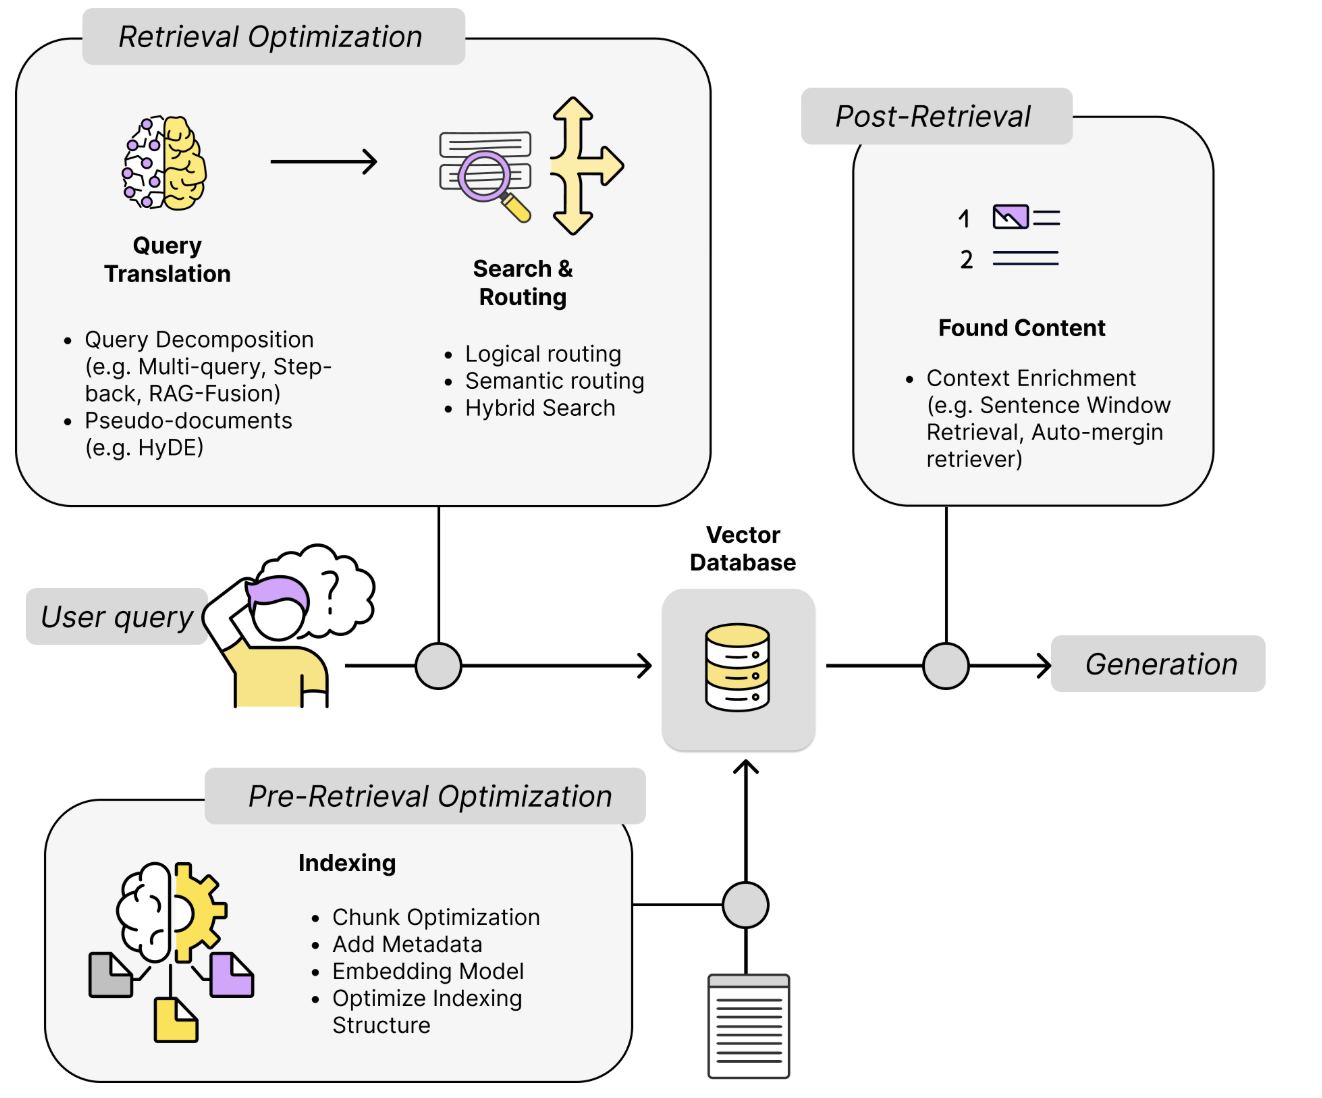

But in real-world RAG workflows, we often combine them. Let's see an example of a complete retrieval process, combining multiple steps and techniques:

1. Start by breaking down a complex question into simpler ones using query decomposition. For example, the question “Was Google’s revenue higher than Microsoft’s in 2022?” can be split into two:
    * “What was Google’s revenue in 2022?”
    * “What was Microsoft’s revenue in 2022?”

2. For each question, perform a search and apply metadata filtering to focus on the most relevant parts of the dataset. You can use a query routing system to direct each question to the best data collection. For example, use the dataset about Microsoft’s financials for one question and Google’s financials for the other.

3. Combine the results and use a reasoning step to create a single, unified answer. Before this, you can add a reranking step to refine the retrieved documents and ensure the most relevant ones are prioritized.

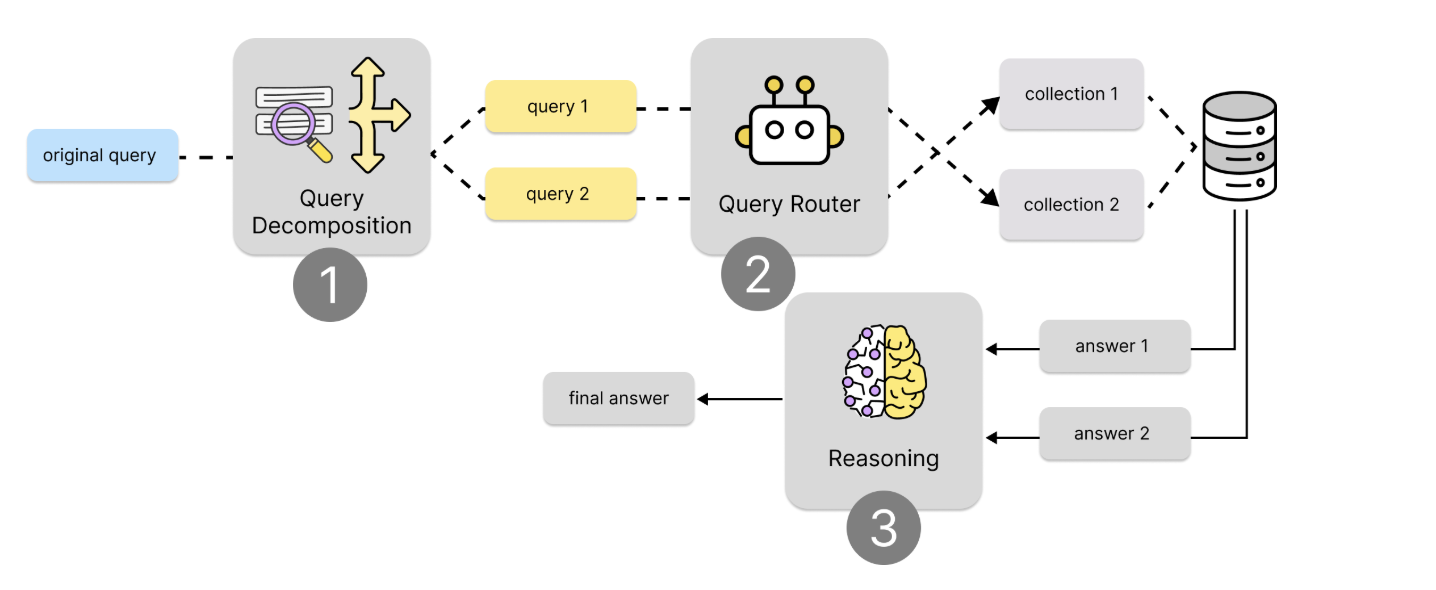

## Setup

This notebook uses the following Python packages:

- `psycopg2` (PostgreSQL database access)
- `requests` (HTTP requests)
- `openai` (OpenAI API access)

In [ ]:
!pip install psycopg2==2.9.10
!pip install requests==2.32.3
!pip install langchain-google-genai pydantic

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

from google.colab import userdata

from numpy.linalg import norm
import pandas as pd
import numpy as np
import os

In [3]:
# --- Configuration ---
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

In [4]:
# Initialize the ChatGoogleGenerativeAI model
# Use a model that supports audio input, like "gemini-1.5-flash" or "gemini-1.5-pro"
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0, api_key=userdata.get("GOOGLE_API_KEY") )

gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

## 1.1 Optimizing Query Results using Metadata Filtering in PostgreSQL

Imagine you’re building a chatbot for a sports website covering football, tennis, and basketball.

A question like “Who is the best player of all time?” is too vague without knowing which sport the user means.

By using what we know about the user, we can make searches more specific and accurate.

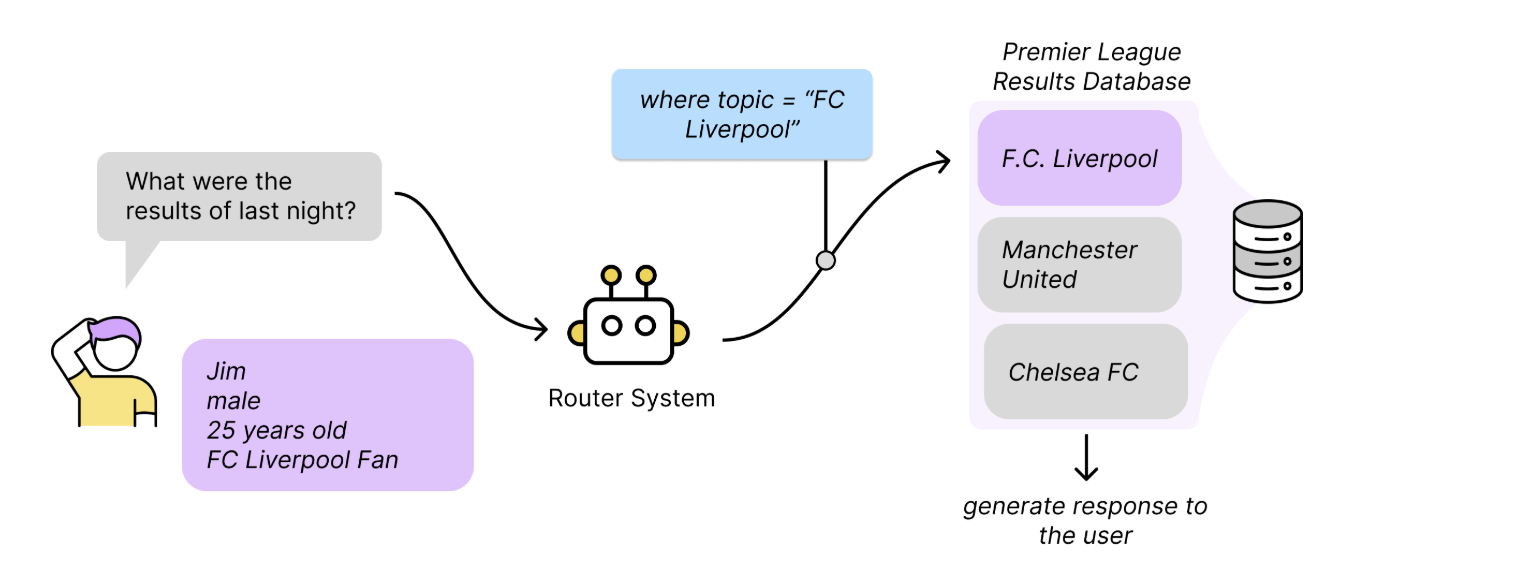

**User Profile Example**: Sarah, 28, tennis enthusiast from New York

When Sarah asks “Who is the best player of all time?” we can focus on tennis players like Serena Williams or Roger Federer

For the question “What were yesterday’s results?” we can prioritize tennis tournament scores over football or basketball games

By using what we know about the user, we can make searches more specific and more relevant.

In [ ]:

def metadata_filtering_using_postgresql():
    """
    This function fills a embeddings table with some data
    from a text about soccer and american football.

    We add the topic as a new metadata field, and finally
    query the embeddings table in PostgreSQL but
    filter the table first.
    """
    import psycopg2
    from openai import OpenAI
    import json

    # Connect to PostgreSQL
    conn = psycopg2.connect(
        dbname="rag_cookbook",
        user="rag_cookbook_user",
        password="rag_cookbook_user_pw",
        host="localhost",
        port="5432",
    )
    cur = conn.cursor()

    # drop the table embeddings_table_with_metadata if exists
    cur.execute("DROP TABLE IF EXISTS embeddings_table_with_metadata")

    # tag::metadata_filtering_create_table[]
    # creates the vector extension if it does not exist
    cur.execute("""CREATE EXTENSION IF NOT EXISTS vector""")

    # Create table with metadata column
    cur.execute(
        """
        CREATE TABLE IF NOT EXISTS embeddings_table_with_metadata (
            id SERIAL PRIMARY KEY,
            text_chunk TEXT,
            embedding VECTOR(1536),
            metadata JSONB
        )
    """
    )
    conn.commit()
    # end::metadata_filtering_create_table[]

    # tag::fill_metadata_table_with_sample_data[]
    # Define text chunks and metadata
    text_chunks = [
        {
            "text": "Roger Federer has won 20 Grand Slam titles in tennis.",
            "topic": "tennis",
        },
        {
            "text": "The FIFA World Cup is the most prestigious football tournament.",
            "topic": "football",
        },
        {
            "text": "Serena Williams is one of the greatest tennis players of all time.",
            "topic": "tennis",
        },
        {
            "text": "Lionel Messi has won multiple Ballon d'Or awards in football.",
            "topic": "football",
        },
    ]
    # Initialize OpenAI client
    client = OpenAI()

    # Insert text chunks with embeddings and metadata
    for chunk in text_chunks:
        # Get embedding using OpenAI API
        response = client.embeddings.create(
            input=chunk["text"],
            model="text-embedding-3-small"
        )
        embedding = response.data[0].embedding

        metadata = {"topic": chunk["topic"]}
        cur.execute(
            "INSERT INTO embeddings_table_with_metadata (text_chunk, embedding, metadata) "
            "VALUES (%s, %s, %s)",
            (chunk["text"], embedding, json.dumps(metadata)),
        )

    conn.commit()
    # end::fill_metadata_table_with_sample_data[]

    # tag::metadata_filtering_in_action[]
    # Query the table with metadata filtering
    query = "Who is the best player?"
    response = client.embeddings.create(
        input=chunk["text"],
        model="text-embedding-3-small"
    )
    query_embedding = response.data[0].embedding
    topic_filter = "football"

    cur.execute(
        f"""
        SELECT text_chunk, 1 - (embedding <=> %s::vector) AS similarity
        FROM embeddings_table_with_metadata
        WHERE metadata->>'topic' = %s
        ORDER BY similarity DESC
        LIMIT 5
        """,
        (query_embedding, topic_filter),
    )
    results = cur.fetchall()
    # end::metadata_filtering_in_action[]

    # Close the connection
    cur.close()
    conn.close()

    return results

results = metadata_filtering_using_postgresql()

In [ ]:
results

[("Lionel Messi has won multiple Ballon d'Or awards in football.",
  0.9999992847442627),
 ('The FIFA World Cup is the most prestigious football tournament.',
  0.3422972747925217)]

## 5.2 Enhancing Search Results by Extending the Original Query with Generated Pseudo-Documents

You want to improve search results by creating pseudo-documents that match the style of real content in your database.

The process is simple:

1. User asks a question
2. LLM generates a hypothetical document that might answer it
3. Search the vector database using this fake document’s embeddings

Then use the retrieved real documents to generate the final answer.

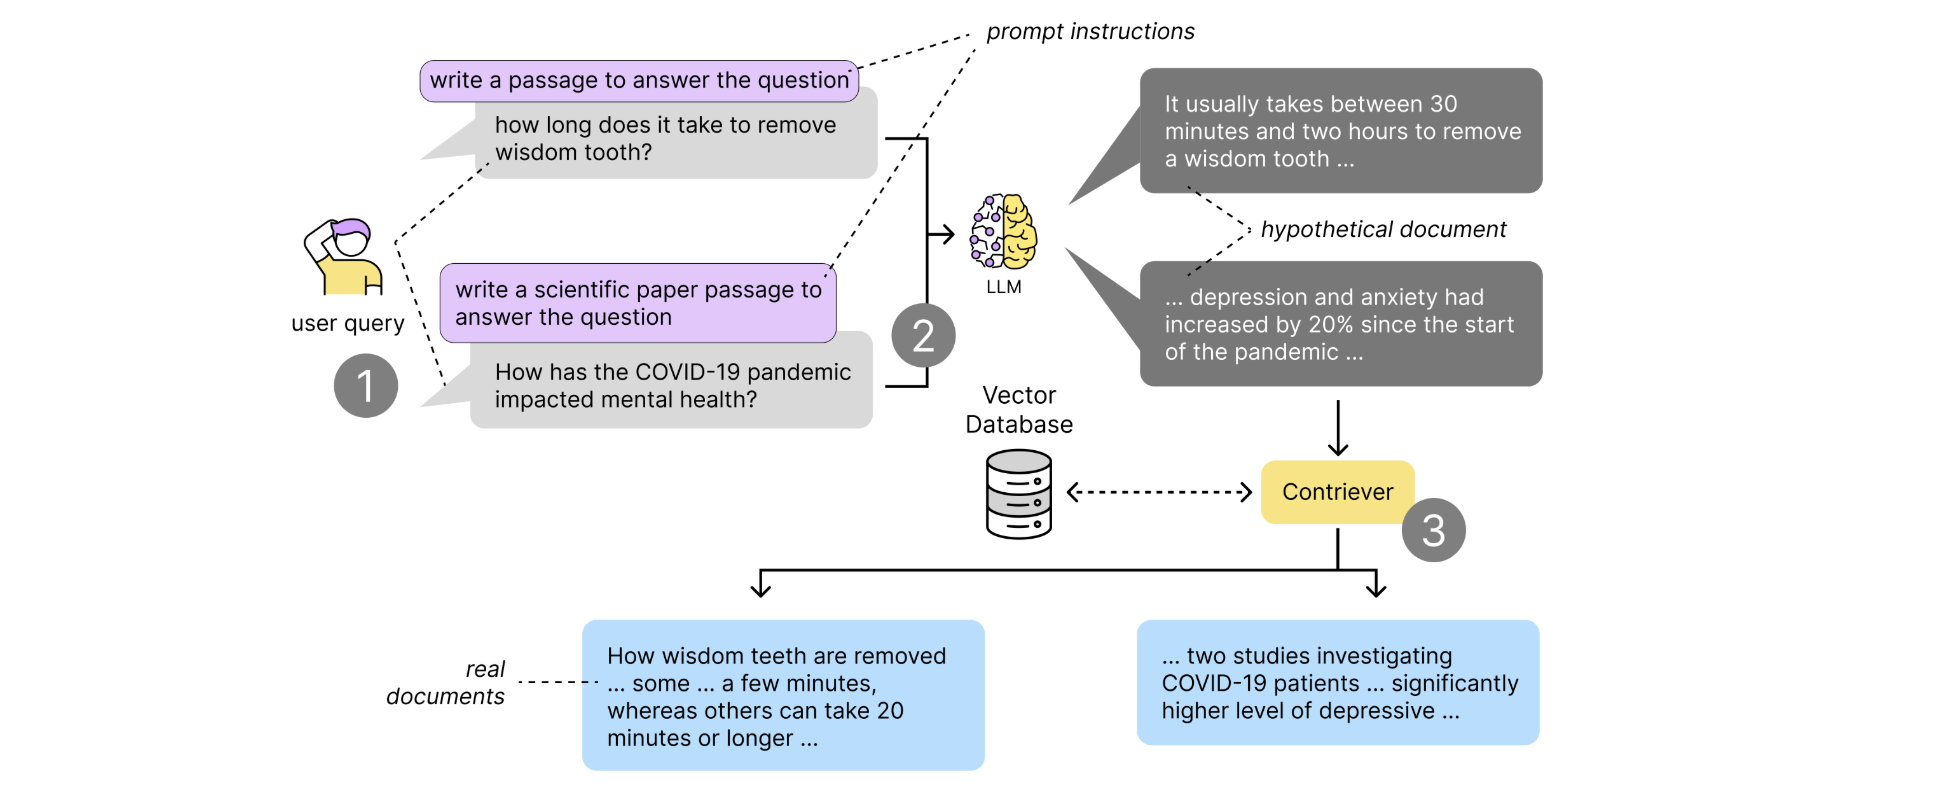

In [ ]:
def generate_hypothetical_documents():
    """
    Generate hypothetical documents for the vector search chapter

    Returns:
        text_chunks (list): List of hypothetical documents
    """
    # tag::generate_hypothetical_documents[]
    from pydantic import BaseModel

    user_query = "What is the revenue of Company X in 2024?"

    class HypotheticalDocuments(BaseModel):
        documents: list[str]

    prompt = f"""
    You are an AI assistant. Based on the user query below, generate three hypothetical
    text chunks that contain relevant information to answer the query.
    """

    messages=[
          {"role": "system", "content": prompt},
          {"role": "user", "content": user_query},
      ]

    structured_llm = llm.with_structured_output(HypotheticalDocuments)
    completion = structured_llm.invoke(messages)

    hypothetical_documents = completion.documents
    # end::generate_hypothetical_documents[]

    return hypothetical_documents

hypothetical_documents = generate_hypothetical_documents()


In [ ]:
hypothetical_documents

["Company X's 2024 annual report states a total revenue of $500 million, primarily driven by strong sales in its technology division.",
 'According to a press release from Company X, their revenue for the first two quarters of 2024 reached $280 million, exceeding internal projections.',
 "An industry analysis report estimates Company X's total revenue for 2024 to be around $520 million, citing market growth and successful product launches."]

## 5.3 Improving Search Results with Multi-Query Retrieval

Multi-query retrieval creates several variations of your original question, searches with each one, then combines all the results for a more comprehensive answer.

The process is straightforward:
1. Take the original query and generate 2-3 alternative phrasings
2. Search the vector database with each query version
3. Merge the retrieved documents and send them to the LLM

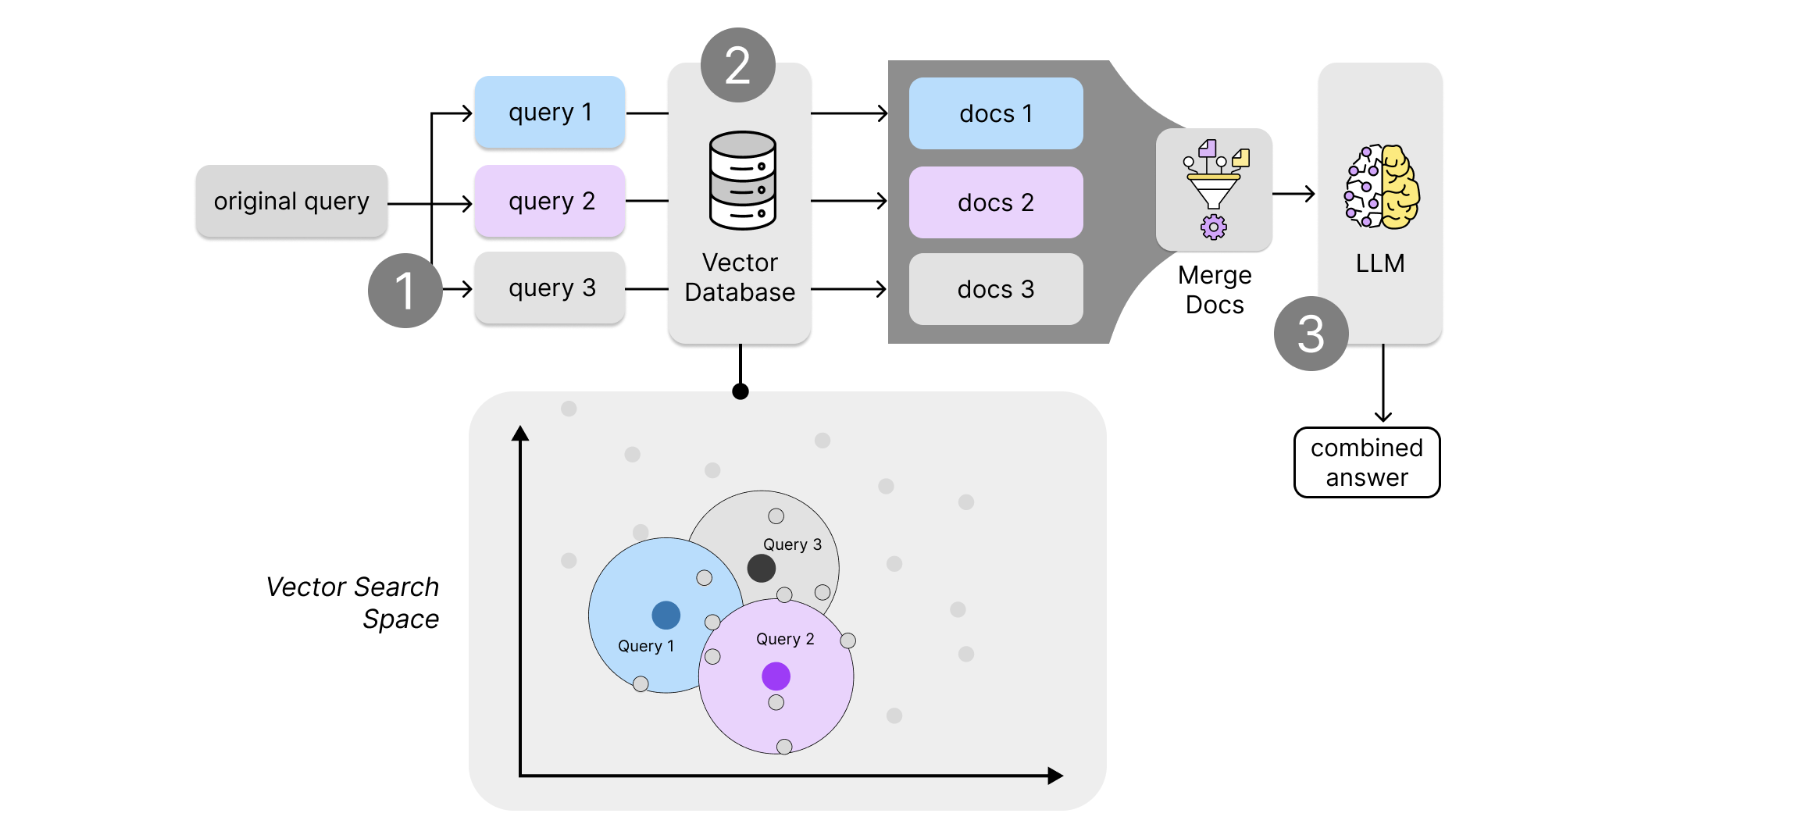

**Example**: A user asks “What are the benefits of renewable energy?”

Multi-query retrieval generates these variations:

1. “What are the environmental benefits of renewable energy?”
2. “How does renewable energy contribute to economic growth?”
3. “What are the drawbacks of renewable energy?”

Each query targets different aspects: environmental impact, economic effects, and potential challenges. Together, they retrieve a more comprehensive set of documents than the original question alone.

In [ ]:
def multi_query_prompting():
    from pydantic import BaseModel

    question = "What are the benefits of renewable energy?"

    query_prompt = f"""You are an AI language model assistant. Your task is
    to create three alternative versions of the provided user original query to
    enhance the retrieval of relevant documents from a vector database.
    By offering diverse variations of the query, your goal is to help
    mitigate the limitations of distance-based similarity search. Provide
    these alternative queries, each on a new line.

    Original query: {question}
    """

    # send the query prompt to OpenAI
    class QueryVariations(BaseModel):
        queries: list[str]


    messages=[
        {
            "role": "user",
            "content": query_prompt,
        },
    ]

    structured_llm = llm.with_structured_output(QueryVariations)
    completion = structured_llm.invoke(messages)

    queries = completion.queries
    return queries

In [ ]:
queries = multi_query_prompting()

In [ ]:
queries

['What are the benefits of renewable energy?']

In [ ]:
queries

['How does renewable energy contribute to environmental sustainability?',
 'What advantages does renewable energy offer over fossil fuels?',
 'In what ways can renewable energy improve economic growth and efficiency?']

## 5.4 Addressing Complex Requests by Designing a Query Routing System

A query routing system directs questions to the right data sources or tools. For example, “What is 1+8?” goes to a calculator, while “What was Google’s revenue?” goes to a financial database.

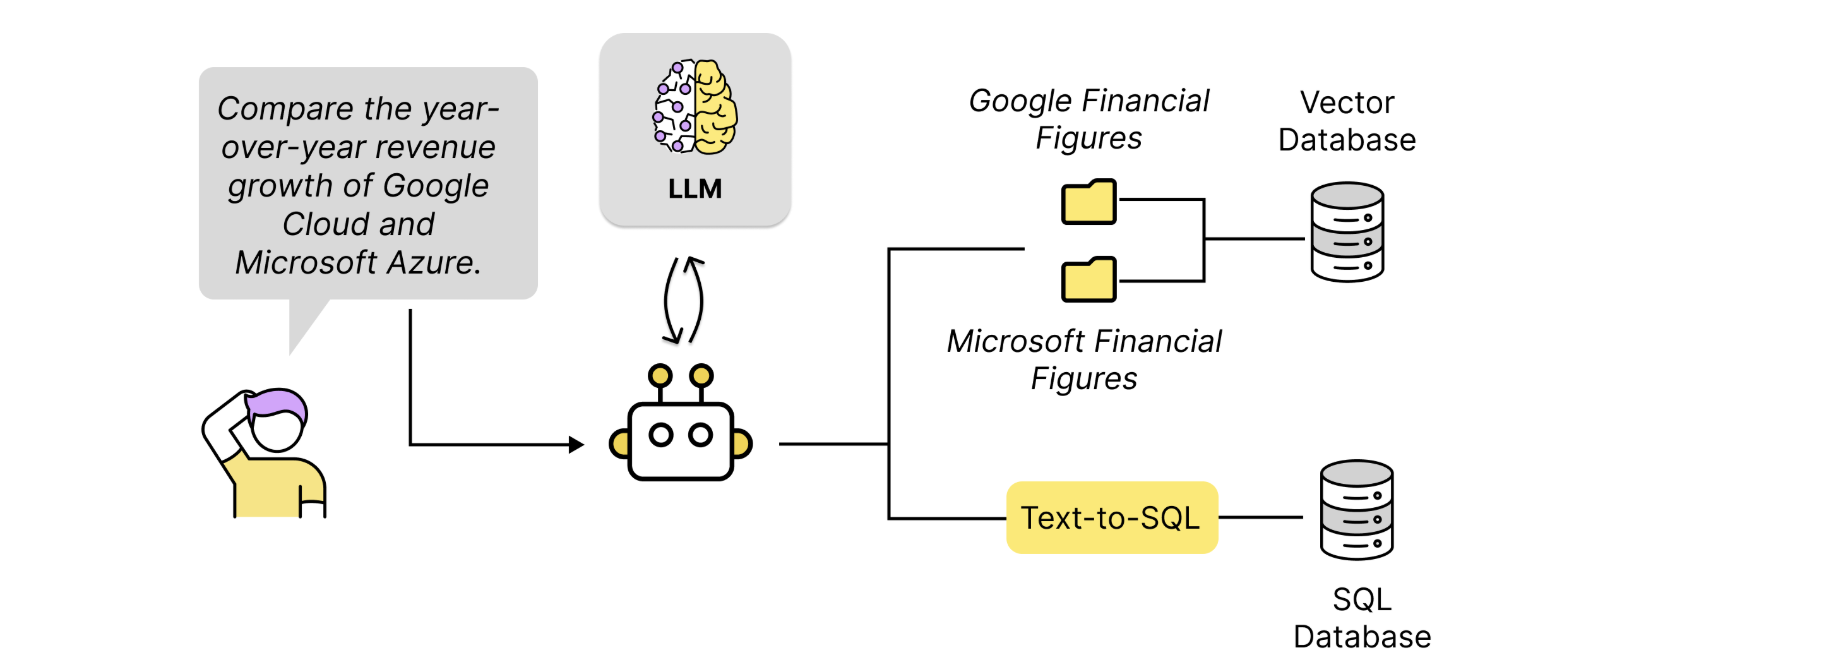

Let's create a prompt that instructs the model to choose between three different tools. In this case, we simulate having three different data sources that we can access using various tools:

* A knowledge pool with information about general football knowledge, such as “What is the offside rule?”
* A knowledge pool with information about general tennis knowledge, such as “How many points does a player typically need to win a tennis game?”
* Additionally, we simulate a connection to a SQL database containing the latest football results. Based on the user’s question, the router should assign one of the following labels: “general_football_knowledge”, “general_tennis_knowledge”, or “latest_football_results_sql”.

The function that returns the user questions as a list of dictionaries. Each dictionary has the user’s query and a selected_data_source field that gets filled with the correct label based on the router’s decision.

In [5]:

def query_routing_system():
    """
    1. Get the user's query and check with the router
    2. The router can decide between functions to use to answer the question
        Those functions can be vector search of different index subsets or other tools,
        like a T2SQL module to query a SQL database

    Returns:
        selected_data_sources (list): The selected data sources for each user query
    """
    # tag::query_routing[]
    from pydantic import BaseModel

    user_queries = [
        {
            "query": "Who is the all-time top scorer in the FIFA World Cup?",
            "selected_data_source": None,
        },
        {
            "query": "What are the four Grand Slam tennis tournaments?",
            "selected_data_source": None,
        },
        {
            "query": "Did Manchester United win their last game?",
            "selected_data_source": None,
        },
    ]

    prompt = f"""
    You are an exptert at routing a user question to the appropraite data source.
    Given a user question choose which of the data sources in list_of_data_sources
    is the best to answer the question.
    """

    from typing import Literal
    from pydantic import Field

    class RouterDecision(BaseModel):
        data_source: Literal[
            "general_football_knowledge",
            "general_tennis_knowledge",
            "latest_football_results_sql",
        ] = Field(
            ..., description="The best data source to answer the user's question."
        )


    structured_llm = llm.with_structured_output(RouterDecision)

    for user_query in user_queries:
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": user_query["query"]},
        ]
        completion = structured_llm.invoke(messages)
        data_source = completion.data_source
        user_query["selected_data_source"] = data_source

    return user_queries

user_queries = query_routing_system()

In [6]:
user_queries

[{'query': 'Who is the all-time top scorer in the FIFA World Cup?',
  'selected_data_source': 'general_football_knowledge'},
 {'query': 'What are the four Grand Slam tennis tournaments?',
  'selected_data_source': 'general_tennis_knowledge'},
 {'query': 'Did Manchester United win their last game?',
  'selected_data_source': 'latest_football_results_sql'}]

## 5.5 Increasing Search Efficiency by Designing an Auto-Merging Retriever (aka Parent Document Retriever)

In [ ]:

def auto_merging_retriever():
    """
    This function demonstrates how to create a table in PostgreSQL
    to store text chunks and their embeddings, and how to insert
    those chunks into the table. It also shows how to create a
    hypothetical dataset of text chunks that are automatically merged
    into parent nodes based on their size.
    """
    import requests

    # tag::auto_merging_retriever_test_data[]
    file_path = "../datasets/text_files/random-text-about-5-different-stories-with-pargraphs.txt"

    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read()

    leaf_node_size = 250  # size of the leaf nodes in characters
    parent_merge = 4  # number of leaf nodes to merge into a parent node
    parent_node_size = (
        parent_merge * leaf_node_size
    )  # size of the parent nodes in characters
    text_chunks = []  # list to store the text chunk dictionaries

    for leaf_node_id in range(0, len(text) // leaf_node_size, 1):
        parent_node_id = leaf_node_id // parent_merge
        leaf_chunk_start = leaf_node_id * leaf_node_size
        parent_chunk_start = parent_node_id * parent_node_size

        text_chunk = {
            "leaf_node_id": leaf_node_id,
            "leaf_chunk": text[leaf_chunk_start : leaf_chunk_start + leaf_node_size],
            "parent_node_id": parent_node_id,
            "parent_chunk": text[
                parent_chunk_start : parent_chunk_start + parent_node_size
            ],
        }
        text_chunks.append(text_chunk)
    # end::auto_merging_retriever_test_data[]

    import psycopg2

    # Connect to PostgreSQL
    conn = psycopg2.connect(
        dbname="rag_cookbook",
        user="rag_cookbook_user",
        password="rag_cookbook_user_pw",
        host="localhost",
        port="5432",
    )
    cur = conn.cursor()

    cur.execute("DROP TABLE IF EXISTS auto_merging_retriever_text_chunks")

    # tag::auto_merging_retriever_create_table[]
    # Create a new table for storing chunks and embeddings
    cur.execute("""CREATE EXTENSION IF NOT EXISTS vector""")

    cur.execute(
        """
        CREATE TABLE auto_merging_retriever_text_chunks (
            leaf_node_id SERIAL PRIMARY KEY,
            leaf_chunk TEXT,
            parent_node_id INTEGER,
            parent_chunk TEXT,
            leaf_chunk_embedding VECTOR(1536)
        )
    """
    )
    conn.commit()
    # end::auto_merging_retriever_create_table[]

    # tag::auto_merging_retriever_insert_data[]
    from openai import OpenAI

    client = OpenAI()  # initialize OpenAI client

    # Insert chunks and their embeddings into the table
    for text_chunk in text_chunks:
        leaf_embedding = (
            client.embeddings.create(
                input=[text_chunk["leaf_chunk"]], model="text-embedding-3-small"
            )
            .data[0]
            .embedding
        )

        cur.execute(
            """
            INSERT INTO auto_merging_retriever_text_chunks
            (leaf_node_id, leaf_chunk, parent_node_id, parent_chunk, leaf_chunk_embedding)
            VALUES (%s, %s, %s, %s, %s)
            """,
            (
                text_chunk["leaf_node_id"],
                text_chunk["leaf_chunk"],
                text_chunk["parent_node_id"],
                text_chunk["parent_chunk"],
                leaf_embedding,
            ),
        )
    conn.commit()
    # end::auto_merging_retriever_insert_data[]

auto_merging_retriever()


OperationalError: connection to server at "localhost" (::1), port 5432 failed: Connection refused (0x0000274D/10061)
	Is the server running on that host and accepting TCP/IP connections?
connection to server at "localhost" (127.0.0.1), port 5432 failed: Connection refused (0x0000274D/10061)
	Is the server running on that host and accepting TCP/IP connections?


In [ ]:
auto_merging_retriever()

### 5.6 Increasing Search Results by Designing a Sentence Window Retriever

In [ ]:

def sentence_window_retriever():
    """
    This function is used in chapter 5 as a example how to create a table in postgres
    """

    # tag::sentence_window_retriever_test_data[]
    file_path = "../datasets/text_files/random-text-about-5-different-stories-with-pargraphs.txt"

    with open(file_path, "r") as file:
        text = file.read()

    # Split the text into sentences
    sentences = text.split(". ")
    text_chunks = []  # list to store the text chunk dictionaries

    for sentence_id, sentence in enumerate(sentences):
        text_chunk = {
            "chunk_id": sentence_id,
            "chunk": sentence,
        }
        text_chunks.append(text_chunk)
    # end::sentence_window_retriever_test_data[]

    import psycopg2

    # Connect to PostgreSQL
    conn = psycopg2.connect(
        dbname="rag_cookbook",
        user="rag_cookbook_user",
        password="rag_cookbook_user_pw",
        host="localhost",
        port="5432",
    )
    cur = conn.cursor()

    cur.execute("DROP TABLE IF EXISTS sentence_window_retriever_text_chunks")

    # Create a new table for storing chunks and embeddings
    cur.execute("""CREATE EXTENSION IF NOT EXISTS vector""")

    # tag::sentence_window_retriever_create_table[]
    cur.execute(
        """
        CREATE TABLE sentence_window_retriever_text_chunks (
            chunk_id SERIAL PRIMARY KEY,
            chunk TEXT,
            chunk_embedding VECTOR(1536)
        )
    """
    )
    conn.commit()
    # end::sentence_window_retriever_create_table[]

    # tag::sentence_window_retriever_insert_data[]
    from openai import OpenAI

    client = OpenAI()  # initialize OpenAI client
    # Insert chunks and their embeddings into the table
    for text_chunk in text_chunks:
        embedding = (
            client.embeddings.create(
                input=[text_chunk["chunk"]], model="text-embedding-3-small"
            )
            .data[0]
            .embedding
        )

        cur.execute(
            """
            INSERT INTO sentence_window_retriever_text_chunks
            (chunk_id, chunk, chunk_embedding)
            VALUES (%s, %s, %s)
            """,
            (
                text_chunk["chunk_id"],
                text_chunk["chunk"],
                embedding,
            ),
        )
    conn.commit()
    # end::sentence_window_retriever_insert_data[]
    # tag::sentence_window_retriever_query_data[]
    # Query the table
    query = "What is the revenue of Company X in 2024?"
    query_embedding = (
        client.embeddings.create(input=[query], model="text-embedding-3-small")
        .data[0]
        .embedding
    )
    cur.execute(
        f"""
        SELECT chunk, 1 - (chunk_embedding <=> '{str(query_embedding)}') AS similarity
        FROM sentence_window_retriever_text_chunks
        ORDER BY similarity DESC
        LIMIT 5
        """
    )
    results = cur.fetchall()
    # end::sentence_window_retriever_query_data[]
    # Close the connection
    cur.close()
    conn.close()
    return results


In [ ]:
results = sentence_window_retriever()

OperationalError: connection to server at "localhost" (::1), port 5432 failed: Connection refused (0x0000274D/10061)
	Is the server running on that host and accepting TCP/IP connections?
connection to server at "localhost" (127.0.0.1), port 5432 failed: Connection refused (0x0000274D/10061)
	Is the server running on that host and accepting TCP/IP connections?


### 5.7 Improving Search Accuracy with Reranking Methods

In [ ]:

def reranking():
    """
    This function is used in chapter 5 as a example how to create
    a table in postgres
    """
    # tag::reranking[]
    import textwrap
    from openai import OpenAI
    from pydantic import BaseModel

    text_chunks = {
        1: "Tesla's Supercharger network and tech lead face rising competition from BYD "
        "and established automakers.",
        2: "Tesla's production grows, but price competition threatens its market share.",
        3: "The automotive industry is shifting to EVs due to climate change and "
        "regulations.",
        4: "Semiconductor shortages are disrupting automotive supply chains.",
        5: "Consumer demand for autonomous driving and advanced tech impacts EV "
        "competition.",
    }

    prompt = textwrap.dedent(
        f""""
        Query: Will Tesla remain the market leader in electric vehicles?

        Documents:
            1. {text_chunks[1]}
            2. {text_chunks[2]}
            3. {text_chunks[3]}
            4. {text_chunks[4]}
            5. {text_chunks[5]}

        Instructions:
        Please assess the relevance of each document to the query and
        provide a relevance score from 1 to 5, where 5 is the most relevant.#

        Relevance Scores:
        """
    )
    # end::reranking[]

    client = OpenAI()  # initialize OpenAI client

    class RankedDocuments(BaseModel):
        text_chunk_ids: list[int]
        relevance_scores: list[int]

    completion = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": prompt},
        ],
        response_format=RankedDocuments,
    )

    ranked_docs = completion.choices[0].message.parsed
    # end::reranking[]
    return ranked_docs

ranked_docs = reranking()

In [ ]:
ranked_docs

RankedDocuments(text_chunk_ids=[1, 2, 3, 4, 5], relevance_scores=[5, 4, 2, 1, 4])

### 5.8 Decomposing Complex Queries into Multiple Sub-Queries

In [ ]:

def query_decomposition():
    """
    Query decomposition using PostgreSQL

    Returns:
        results (list): List of results
    """
    # tag::query_decomposition_using_postgresql[]
    from pydantic import BaseModel
    from typing import Optional
    from openai import OpenAI

    class Question(BaseModel):
        question: str
        answer: Optional[str] = None

    class Questions(BaseModel):
        questions: list[Question]

    splitter_prompt = """
    You are a helpful assistant for a RAG chatbot.

    Your job is to break down complex questions into simpler ones that are easy to
    answer. When the answers to these simpler questions are combined, they should
    fully answer the original question. If the question is already simple, leave
    it as it is. Handle one question at a time.

    Example:
        1. Query: Did Microsoft or Google make more money last year?

    Decomposed Questions:
       1. How much profit did Microsoft make last year?
       2. How much profit did Google make last year?
    """
    # end::query_decomposition_using_postgresql[]

    # tag::query_decomposition_prompt[]
    client = OpenAI()

    query = "What are the benefits of renewable energy compared to fossil fuels?"

    completion = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": splitter_prompt},
            {"role": "user", "content": query},
        ],
        response_format=Questions,
    )

    decomposed_questions = completion.choices[0].message.parsed.questions
    # end::query_decomposition_prompt[]

    return decomposed_questions

decomposed_questions = query_decomposition()

In [ ]:
decomposed_questions

[Question(question='What are the benefits of renewable energy?', answer=None),
 Question(question='What are the benefits of using fossil fuels?', answer=None),
 Question(question='How does renewable energy impact the environment compared to fossil fuels?', answer=None),
 Question(question='How does the cost of renewable energy compare to fossil fuels?', answer=None),
 Question(question='What is the availability and scalability of renewable energy compared to fossil fuels?', answer=None)]